# The Data
Some chemical company has decided to produce chemical $C$ by reacting chemicals $A$ and $B$ semi-batchwise.  They have carried out one long batch run where they sampled at about 1 minute intervals.  Their analytical equipment is such that only the concentrations of $A$ and $C$ could be measured along with the total volume of the reaction mixture (as $A$ is added semi-batch wise) in a solution with concentration $C_{A0}$.  The data is available at <code> kinetic_data.xlsx </code>.

In [1]:
import scipy
import scipy.integrate
import scipy.optimize
import scipy.linalg
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In the data below, $V$ is in litres, the concentrations are kmol/m3 i.e. mol/litre.  Time is in seconds.

In [2]:
df_kinetic_data = pd.read_excel("kinetic_data.xlsx", sheetname="Data")
df_kinetic_data

,Time,V,CA,CC,errV,errCA,errCC
0,0.000000,4.739251,0.000000,0.000000,0.473581,0.000000,0.000000
1,51.724138,5.644829,0.017682,0.028785,0.491683,0.001768,0.002879
2,103.448276,5.804559,0.022045,0.068567,0.464215,0.002205,0.006857
3,155.172414,6.991923,0.020795,0.100657,0.489110,0.002079,0.010066
4,206.896552,6.863593,0.023613,0.120995,0.467691,0.002361,0.012099
5,258.620690,7.607078,0.024712,0.147618,0.512939,0.002471,0.014762
6,310.344828,7.795172,0.026317,0.167573,0.545415,0.002632,0.016757
7,362.068966,9.353354,0.028408,0.198698,0.461245,0.002841,0.019870
8,413.793103,9.400610,0.027175,0.192747,0.484113,0.002718,0.019275
9,465.517241,10.470724,0.029383,0.210341,0.461213,0.002938,0.021034


This we have to fit to a model and extract parameters and uncertainties.  The model is necessarily non-linear. Unlike the linear models, there is no simple analytical way to get the best fit parameters.  These have to be obtained by numerical iteration.  So let's first make our model.  

Let's postulate:
$$
    A + B \rightarrow C
$$
We have no reason, right now, to assume anything else.  

We will skip over the shell balances etc and just write down the differential equations:
$$
    \frac{dN_A}{dt} = v_0C_{A0} - Vk_{AB}C_AC_B 
$$
where $v_0$ is the volumetric rate of addition of the solution of A with concentration $C_{A0}$ and $k_{AB}$ is the kinetic constant for the reaction.
$$
    \frac{dN_B}{dt} = -Vk_{AB}C_AC_B
$$
And,
$$
    \frac{dN_C}{dt} = Vk_{AB}C_AC_B
$$
And last, but not the least,
$$
    \frac{dV}{dt} = v_0
$$

### Model 1
Let's turn this into code.

In [3]:
def model1(SV, t, parameters):
    [NA, NB, NC, V] = SV
    
    kAB = parameters["kAB"]
    v0 = parameters["v0"]
    CA0 = parameters["CA0"]
    
    CA = NA/V
    CB = NB/V
    CC = NC/V
    
    dNAbydt = -V*kAB*CA*CB + v0*CA0
    dNBbydt = -V*kAB*CA*CB
    dNCbydt =  V*kAB*CA*CB
    dVbydt  =  v0
    
    return [dNAbydt, dNBbydt, dNCbydt, dVbydt]

Let's assume we know $C_{A0}$ = 0.5 $\frac{kmol}{m^3}$.  Also, the concentration of $B$ in the vessel is $C_{B0} = 1.0$ kmol/m3.  We need to find $k_{AB}$ and $v_0$.  Why do we have to find $v_0$?  Because the people who did the experiment did not keep tabs of it.  They just dribbled in the solution of $A$ through a an overflow and forgot to measure the flowrate.  Fortunately, their level indicator did keep a record of the volume in the vessel. 

To estimate these parameters we have to follow an iterative procedure.  We guess the parameters, find out the profiles corresponding to these guesses.  Compare with the experimental results.  And refine the guess.  This can all be outsourced to powerful optimization algorithms.  We just have to write the function for getting the $\chi^2$.


Now let's prepare our parameters.  The unknown ones we guess.

In [4]:
parameters = {
    "CA0":0.5, #kmol/m3
    "CB0":1.0, #kmol/m3
    "kAB":0.01, #SI units  GUESS (a very naive guess!).  Retry with a guess of 0.01
    "v0":0.01e-3, #m3/s GUESS (a very naive guess!)         Retry with a guess of 0.01e-3
}

In [5]:
def solution1(parameters, df_kinetic_data):
    #Get the independent variable
    t = df_kinetic_data["Time"]
    
    #Lets prepare our SV0
    V0 = df_kinetic_data.iloc[0]["V"]*0.001 #V0 is in litres.  Convert to m3
    NA0 = df_kinetic_data.iloc[0]["CA"]*V0 #kmol
    NB0 = parameters["CB0"]*V0 #kmol
    NC0 = df_kinetic_data.iloc[0]["CC"]*V0 #kmol
    SV0 = [NA0, NB0, NC0, V0] 
    
    #Solve with best guess of the parameters to be fitted
    solution = scipy.integrate.odeint(model1, SV0, t, args=(parameters,))
    NA = solution[:,0]
    V = solution[:,3]  #be careful with the indices!
    CA_calc = NA/V
    
    return CA_calc

Now we need to get the residuals.  Let's, for a start, try to predict only $C_A$. Hence we wish to minimize:
$$
    \chi^2_{A} = \sum_i{\left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right)^2}
$$
where $\sigma_{C_Ai}$ is the uncertainty in $C_{Ai}$.  We will be using the powerful optimizaton module <code> scipy.optimize.least_squares</code>.  You can see how it works by typing <code>help(scipy.optimize.least_squares)</code> in a code cell.  To do so, it requires that you write a function take takes in values of the guess parameters are returns an array of residuals i.e. an array of $\left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right)$.  It will spit out the optimized parameters.  So let's do that.


In [6]:
def get_residuals(parameters_to_fit, parameters, df_kinetic_data):
    CA_expt = df_kinetic_data.iloc[1:]["CA"]   # we are not going to fit the initial condition
    errCA = df_kinetic_data.iloc[1:]["errCA"]
    
    [kAB, v0] = parameters_to_fit #The values here (first argument to the function) are automatically modified for optimization
    parameters["kAB"] = kAB  #Now we have our best guess of kAB
    parameters["v0"] = v0    #And our best guess of v0
    
    CA_calc = solution1(parameters, df_kinetic_data)
    
    CA_calc = CA_calc[1:] #We are not fitting the initial condition.
    residuals = (CA_calc - CA_expt)/errCA #This generates the array of residuals.  
    return residuals
    

Now let's deploy the optimization algorithm! 

In [7]:
optimized_parameters = scipy.optimize.least_squares(get_residuals, #our function
                                                    [parameters["kAB"], parameters["v0"]], #initial guess of parameters
                                                    args = (parameters, df_kinetic_data,)) #other important arguments

From the help section of this module (<code>help(scipy.optimize.least_squares)</code>), we see that the object that we have caught in the variable called <code>optimized_parameters</code> is actually a dictionary with several keys.  Two of them are important to us: <code>'x'</code> which returns the optimized parameters and <code>'cost'</code> which returns a measure of the poorness of the fit: this value should be as low as possible.  So let's see what we have.

In [8]:
optimized_parameters['x'], optimized_parameters['cost']

(array([  4.10512427e-02,   8.38836121e-06]), 2.5097412261286367)

So it has updated $k_{AB}$ and $v_0$.

In [9]:
parameters["kAB"] = optimized_parameters['x'][0]
parameters["v0"]  = optimized_parameters['x'][1]
CA_calc = solution1(parameters, df_kinetic_data)

### Importance of the initial guess
Often, if the inital guess is bad, the system will converge to sub-optimal values.  So if your fit is bad, try varying the initial guess to see if that changes anything.  Often it does. 

## A Quick Dekko
Let's have a quick look at the fit.  We will use matplotlib.  

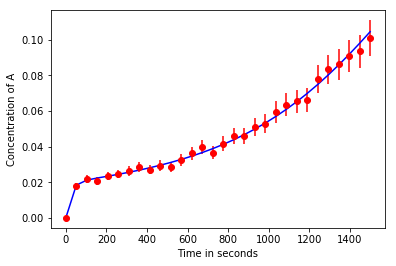

In [10]:
plt.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CA"], 
             yerr=df_kinetic_data["errCA"],
             color = 'r', fmt = 'o', ecolor = 'r', capthick = 2)
plt.plot(df_kinetic_data["Time"], CA_calc, 'b')
plt.xlabel("Time in seconds")
plt.ylabel("Concentration of A")

So that's pretty cool!  You can see that the algorithm has really tried to get the best fit given the constraints imposed by our model.  

### Analysis of Residuals
Let's take a look at the residuals.

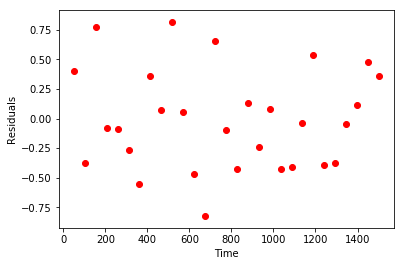

In [11]:
residuals = get_residuals(optimized_parameters["x"], parameters, df_kinetic_data)
plt.scatter(df_kinetic_data.iloc[1:]["Time"], residuals, color = 'red')
plt.xlabel("Time")
plt.ylabel("Residuals")

For a good model, the residuals should be normally distributed about zero.  It appears to be the case here.  But we can be quantitative about it using the Shapiro-Wilk test, which tests for normality of a distribution.  This test is availabe to us via the <code>scipy.stats.shapiro</code> module. For more information type <code>help(scipy.stats.shapiro)</code>.  The null hypothesis of this test is that the data is drawn from a normally distributed sample.  At a significance of 95%, the $p$ value of this test should be less than 0.05 for the null hypothesis to be rejected.

In [12]:
scipy.stats.shapiro(residuals) #first term is the test statistics, second term is the p-value

(0.9651999473571777, 0.4379933476448059)

Since the p value is greater than 0.05, we cannot reject the null hypothesis that the residuals are normally distributed. Which means that the residuals _are_ normally distributed.  Great! 

In [13]:
scipy.mean(residuals), scipy.sqrt(scipy.var(residuals))*1.96

(-0.009059280986700148, 0.81523638631570361)

Further, the residuals have a mean of zero within 95% confidence interval.  

So this model works!  Let's will do the error analysis for it.  It will familiarize us for what is coming later.

## Error Analysis
First thing we need is to get the Covariance Matrix **$C$**.  For which we need the matrix **$A$**.  However, unlike linear least squares, there are not basis functions here.  The elements of **$A$** are (in a generalized way):
$$
    A_{ij} = \frac{\partial y_{i}^{(calc)}}{\partial a_j}\frac{1}{\sigma_{y_i}} = \frac{d_{ij}}{\sigma_{y_i}}
$$
In our case $y_i^{(calc)} = C_{Ai}^{(calc)}$ and the optimized parameters are $a_0$ corresponding to $k_{AB}$ and $a_1$ corresponding to $v_0$.  The partial derivative is called $d_{ij}$ and works like the $j^{th}$ basis function of the $i^{th}$ observation in a linear-least squares analysis.  This matrix has $N$ rows and 2 columns where $N$ is the number of observations used in the fitting.  In our case that is 29 since we are not using the initial values in the fit.  

**NOTE**: Since a residual $r_i = \left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right)$, we can also write $A_{ij} = \frac{\partial r_i}{\partial a_j}$
This will be useful later. 

Now, the only way of getting the elements is numerically.  So let's do that.  

In [14]:
kAB_opt, v0_opt = optimized_parameters['x']

parameters["kAB"], parameters["v0"] = kAB_opt, v0_opt
CA_calc_opt = solution1(parameters, df_kinetic_data)  #CA at optimized parameters

dn = 0.0001 #small increment for numerical differentiation 

parameters["kAB"], parameters["v0"] = kAB_opt*(1+dn), v0_opt
CA_calc_1 = solution1(parameters, df_kinetic_data)

parameters["kAB"], parameters["v0"] = kAB_opt, v0_opt*(1+dn)
CA_calc_2 = solution1(parameters, df_kinetic_data)

d1 = (CA_calc_1 - CA_calc_opt)/(kAB_opt*dn) #numerical differentiation
d2 = (CA_calc_2 - CA_calc_opt)/(v0_opt *dn) #numerical differentiation
#But because we are not taking the initial value,
d1 = d1[1:]
d2 = d2[1:]

Now that we have the d's lets get the $A$.  Make sure you understand what the lines of code mean. 

In [15]:
errCA = df_kinetic_data.iloc[1:]["errCA"]
A = scipy.array([list(d1/errCA), list(d2/errCA)]).T

Now let's get the $H$ matrix:

In [16]:
H = scipy.dot(A.T, A)
H

array([[  7.80639554e+05,  -7.85457925e+09],
       [ -7.85457925e+09,   1.09851848e+14]])

The inverse of this is the covariance matrix **$C$**.  To get the inverse, we have to use <code>scipy.linalg.inv</code>.  

In [17]:
C = scipy.linalg.inv(H)
print('Covariance Matrix')
print(C)
print("C*H")
print(scipy.dot(C, H))

Covariance Matrix
[[  4.56569235e-06   3.26454157e-10]
 [  3.26454157e-10   3.24451533e-14]]
C*H
[[ 1.  0.]
 [ 0.  1.]]


Great!  Now we can get the uncertainties in $k_{AB}$ and $v_0$.

In [18]:
print('kAB',parameters["kAB"])
print('Uncertainty in kAB:',
      1.96*scipy.sqrt(C[0,0]),
      'i.e.',
      1.96*scipy.sqrt(C[0,0])/parameters["kAB"]*100,
      'percent.')
print('95 percent confidence interval for k_AB: (',
      parameters['kAB']-1.96*scipy.sqrt(C[0,0]),
      ',',
      parameters['kAB']+1.96*scipy.sqrt(C[0,0]),
      ')')

kAB 0.0410512426746
Uncertainty in kAB: 0.00418802623498 i.e. 10.2019475225 percent.
95 percent confidence interval for k_AB: ( 0.0368632164396 , 0.0452392689095 )


In [19]:
print('v0',parameters["v0"], 'm3/s')
print('Uncertainty in v0:',
      1.96*scipy.sqrt(C[1,1]),'m3/s i.e.'
      ,1.96*scipy.sqrt(C[1,1])/parameters["v0"]*100,
      'percent.')
print('95 percent confidence interval for v0 (m3/s): ('
      ,parameters['v0']-1.96*scipy.sqrt(C[1,1]),
      ',',
      parameters['v0']+1.96*scipy.sqrt(C[1,1]),
      ')')

v0 8.38920004268e-06 m3/s
Uncertainty in v0: 3.53045748798e-07 m3/s i.e. 4.20833627762 percent.
95 percent confidence interval for v0 (m3/s): ( 8.03615429388e-06 , 8.74224579148e-06 )


### Uncertainty in the best fit.
And now for the grand finale (not really, there is more).  The uncertainty in the best fit line.  
$$
    \sigma_y(t) = \matrix{d^T(t)}\cdot \matrix{C} \cdot \matrix{d(t)}
$$
Here $\matrix{d(t)}^T = [d_1(t), d_2(t)]$. <br>
**Note**: To calculate $\matrix{d(t)}$ at any value of $t$, you will have to do the numerical differentiation.  If this is cumbersome, it is best to calculate $\matrix{d}$ for a large number of values of $t$ and interpolate between them.  We have already done something like this when we got $d_1$ and $d_2$ above.

In [20]:
D = scipy.array([list(d1), list(d2)]).T #Compare with how we got A above.

Now each _row_ of $D$ is a vector $d(t_j)^T$ corresponding to the $j^{th}$ observation. Hence, the array or uncertainties in the best fit curve is as follows (let's not do any fancy array algebra here.  We will use old-fashioned for loops).

In [21]:
sigma_CA = []
for d in D:
    sig = scipy.dot(d, scipy.dot(C, d.T))
    sigma_CA.append(1.96*scipy.sqrt(sig)) #Where we have used the 95% interval.
sigma_CA = scipy.array(sigma_CA)
upper_bound_CA = CA_calc[1:] + sigma_CA
lower_bound_CA = CA_calc[1:] - sigma_CA
time = df_kinetic_data.iloc[1:]["Time"]

So let's plot the fit with the error in the best fit line.

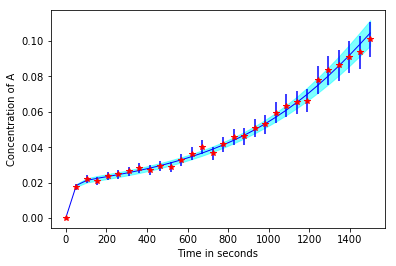

In [22]:
plt.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CA"], 
             yerr=df_kinetic_data["errCA"],
             color = 'red', fmt = '*', ecolor = 'blue', capthick = 0.05)
plt.plot(df_kinetic_data["Time"], CA_calc, 'blue', linewidth = 1.0)
plt.fill_between(time, lower_bound_CA, upper_bound_CA, color='cyan', alpha = 0.5)
plt.xlabel("Time in seconds")
plt.ylabel("Concentration of A")

The cyan region is the 95% confidence region of the best fit line.  Notice that the uncertainty grows as time passes.  Pretty cool!     

## Effect of Additional Data
How about we bring in more data? We have still not used the values of $C_C$.  What difference will bringing those in make?  Well, for one thing, we will have more residuals: those corresponding to $C_A$ and those corresponding to $C_C$.  This brings its own problems, as we will see in a minute.  First, lets modify the <code>solution1</code> function to return $C_A^{(calc)}$ and $C_C^{(calc)}$.

In [23]:
def solution2(parameters, df_kinetic_data):
    #Get the independent variable
    t = df_kinetic_data["Time"]
    
    #Lets prepare our SV0
    V0 = df_kinetic_data.iloc[0]["V"]*0.001 #V0 is in litres.  Convert to m3
    NA0 = df_kinetic_data.iloc[0]["CA"]*V0 #kmol
    NB0 = parameters["CB0"]*V0 #kmol
    NC0 = df_kinetic_data.iloc[0]["CC"]*V0 #kmol
    SV0 = [NA0, NB0, NC0, V0] 
    
    #Solve with best guess of the parameters to be fitted
    solution = scipy.integrate.odeint(model1, SV0, t, args=(parameters,))
    NA = solution[:,0]
    NC = solution[:,2]
    V = solution[:,3]  #be careful with the indices!
    CA_calc = NA/V
    CC_calc = NC/V
    
    return CA_calc, CC_calc

Now we need to get the residuals. But now we have two sets of data.  Hence we wish to minimize, as before:
$$
    \chi^2_{A} = \sum_i{\left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right)^2}
$$
where $\sigma_{C_Ai}$ is the uncertainty in $C_{Ai}$.  
But we also wish to minimize:
$$
    \chi^2_{C} = \sum_i{\left(\frac{C_{Ci}^{(calc)}-C_{Ci}^{(exp)}}{\sigma_{C_{Ci}}}\right)^2}
$$
where $\sigma_{C_Ci}$ is the uncertainty in $C_{Ci}$.  

So the residual generator that we send to <code> scipy.optimize.least_squares</code> should return an array of residuals of both types i.e. an array of $\left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right)$ along with an array of $\left(\frac{C_{Ci}^{(calc)}-C_{Ci}^{(exp)}}{\sigma_{C_{Ci}}}\right)$.  

One obvious problem with this arrangement is that the $C_C$ residuals need not be of the same magnitude as the $C_A$ residuals.  If they are smaller, it will automatically mean that the $C_A$ residuals are weighted higher by the algorithm i.e. it will try to fit $C_A$ better at the expense of a poor fit of $C_C$.  We should find a way of making sure both sets of residuals are approximately of the same order.  We can do this straightforwardly be _scaling_ each residual by an appropriate factor.  The simplest way of doing this is by dividing each by the average value of $C_A$ or $C_C$.  Hence the residuals are: $\left(\frac{C_{Ai}^{(calc)}-C_{Ai}^{(exp)}}{\sigma_{C_{Ai}}}\right) \frac{1}{C_A^{(average)}}$ and $\left(\frac{C_{Ci}^{(calc)}-C_{Ci}^{(exp)}}{\sigma_{C_{Ci}}}\right) \frac{1}{C_C^{(average)}}$. But there are other ways.

However, there is another, tricker problem.  All of our error analysis is set up around a single independent variable.  Now we are faced with two (in other cases more).  The general class of such problems is __Multivariate Multiple Regression__ and the theory is pretty dense (see <a href="https://scse.d.umn.edu/sites/scse.d.umn.edu/files/cassiequickfinalpaper.pdf">here</a>).  

So we won't do that. We will just send a doubly long array of residuals.  

In [24]:
def get_residuals2(parameters_to_fit, parameters, df_kinetic_data, bool_signed = False):
    CA_expt = df_kinetic_data.iloc[1:]["CA"]   # we are not going to fit the initial condition
    errCA = df_kinetic_data.iloc[1:]["errCA"]
    CC_expt = df_kinetic_data.iloc[1:]["CC"]
    errCC = df_kinetic_data.iloc[1:]["errCC"]
    
    CA_avg = scipy.mean(CA_expt)
    CC_avg = scipy.mean(CC_expt)
    
    wCA = 1.0/CA_avg
    wCC = 1.0/CC_avg

    [kAB, v0] = parameters_to_fit #The values here (first argument to the function) are automatically modified for optimization
    parameters["kAB"] = kAB  #Now we have our best guess of kAB
    parameters["v0"] = v0    #And our best guess of v0
    
    CA_calc, CC_calc = solution2(parameters, df_kinetic_data)
    
    CA_calc = CA_calc[1:] #We are not fitting the initial condition.
    CC_calc = CC_calc[1:]
    residuals_CA = wCA*(CA_calc - CA_expt)/errCA 
    residuals_CC = wCC*(CC_calc - CC_expt)/errCC   
    residuals = scipy.concatenate([residuals_CA, residuals_CC])
    return residuals

Now let's deploy the optimization algorithm! 

In [25]:
kAB_opt, v0_opt = optimized_parameters['x'] #from the earlier model
parameters["kAB"], parameters["v0"] = kAB_opt, v0_opt

optimized_parameters2 = scipy.optimize.least_squares(get_residuals2, #our function
                                                    [parameters["kAB"], parameters["v0"]], #initial guess of parameters
                                                    args = (parameters, df_kinetic_data,)) #other important arguments

In [26]:
print('Initial Guess of Parameters',kAB_opt, v0_opt)
print('Optimized Parameters', optimized_parameters2['x'])
print('Cost Function',optimized_parameters2['cost']) 

Initial Guess of Parameters 0.0410512426746 8.38836120656e-06
Optimized Parameters [  4.13214504e-02   8.41392954e-06]
Cost Function 1564.13464731


So the parameters did change, but not significantly.  They are still within their original uncertainties.   

### Another Quick Dekko
Lets have a look at the fits. 

In [27]:
parameters["kAB"], parameters["v0"] = optimized_parameters2["x"]
CA_calc, CC_calc = solution2(parameters, df_kinetic_data)

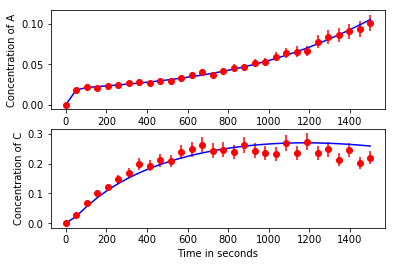

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CA"], 
             yerr=df_kinetic_data["errCA"],
             color = 'r', fmt = 'o', ecolor = 'r', capthick = 2)
ax1.plot(df_kinetic_data["Time"], CA_calc, 'b')
ax1.xaxis.label.set_text("Time in seconds")
ax1.yaxis.label.set_text("Concentration of A")

ax2.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CC"], 
             yerr=df_kinetic_data["errCC"],
             color = 'r', fmt = 'o', ecolor = 'r', capthick = 2)
ax2.plot(df_kinetic_data["Time"], CC_calc, 'b')
ax2.xaxis.label.set_text("Time in seconds")
ax2.yaxis.label.set_text("Concentration of C")

Oh no!  Correlated residuals!  Not good.  

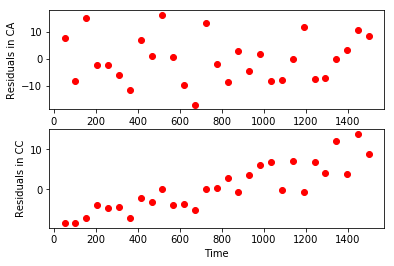

In [29]:
residuals = get_residuals2(optimized_parameters2["x"], 
                           parameters, 
                           df_kinetic_data, 
                           bool_signed = True) #We are using signed residuals
residuals_CA = residuals[:int(len(residuals)/2)]
residuals_CC = residuals[int(len(residuals)/2):]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(df_kinetic_data.iloc[1:]["Time"], residuals_CA, color = 'red')
ax1.xaxis.label.set_text("Time")
ax1.yaxis.label.set_text("Residuals in CA")

ax2.scatter(df_kinetic_data.iloc[1:]["Time"], residuals_CC, color = 'red')
ax2.xaxis.label.set_text("Time")
ax2.yaxis.label.set_text("Residuals in CC")

In [30]:
print("Shapiro-Wilk statistic and p-value for CA residuals",scipy.stats.shapiro(residuals_CA))
print("Shapiro-Wilk statistic and p-value for CC residuals",scipy.stats.shapiro(residuals_CC))
print('Mean and 95% confidence half-width for CA residuals',scipy.mean(residuals_CA), scipy.sqrt(scipy.var(residuals_CA))*1.96)
print('Mean and 95% confidence half-width for CC residuals',scipy.mean(residuals_CC), scipy.sqrt(scipy.var(residuals_CC))*1.96)

Shapiro-Wilk statistic and p-value for CA residuals (0.968377411365509, 0.5165526866912842)
Shapiro-Wilk statistic and p-value for CC residuals (0.9584166407585144, 0.30031222105026245)
Mean and 95% confidence half-width for CA residuals -0.0474426266356 16.6888618545
Mean and 95% confidence half-width for CC residuals 0.403939079014 11.6294892035


There is a definite pattern in the $C_C$ residuals! The residuals are correlated.  The Shapiro test missed it, but there it is.  This is because model in unable to capture the _decrease_ in $C_C$ with time.  Which is expected, since we haven't made any provision for it.  We have to update our model to incorporate the variation we see in $C_C$.
We will put in a model for decay of C.
Now there have been some iterations which will be boring to reproduce here.  For example the model
The model:
$$
    C \rightarrow D
$$
where $D$ stands for degradation products, resulted in correlated residuals. 
The model:
$$
    C + A \rightarrow D
$$
got the uncorrelated signed residuals and the results we see below.  The additional kinetic constant to be fitted is $k_C$.

In [31]:
def model2(SV, t, parameters):
    [NA, NB, NC, V] = SV
    
    kAB = parameters["kAB"]
    v0 = parameters["v0"]
    CA0 = parameters["CA0"]
    kC = parameters["kC"] #notice the additional fitting parameter.
    
    CA = NA/V
    CB = NB/V
    CC = NC/V
    
    dNAbydt = -V*kAB*CA*CB + v0*CA0 - V*kC*CC*CA #Notice the additional term for decay in C
    dNBbydt = -V*kAB*CA*CB
    dNCbydt =  V*kAB*CA*CB - V*kC*CC*CA #Notice the additional term for decay in C
    dVbydt  =  v0
    
    return [dNAbydt, dNBbydt, dNCbydt, dVbydt]

In [32]:
def solution3(parameters, df_kinetic_data):
    #Get the independent variable
    t = df_kinetic_data["Time"]
    
    #Lets prepare our SV0
    V0 = df_kinetic_data.iloc[0]["V"]*0.001 #V0 is in litres.  Convert to m3
    NA0 = df_kinetic_data.iloc[0]["CA"]*V0 #kmol
    NB0 = parameters["CB0"]*V0 #kmol
    NC0 = df_kinetic_data.iloc[0]["CC"]*V0 #kmol
    SV0 = [NA0, NB0, NC0, V0] 
    
    #Solve with best guess of the parameters to be fitted
    solution = scipy.integrate.odeint(model2, SV0, t, args=(parameters,)) #Note we have used model2
    NA = solution[:,0]
    NC = solution[:,2]
    V = solution[:,3]  #be careful with the indices!
    CA_calc = NA/V
    CC_calc = NC/V
    
    return CA_calc, CC_calc

In [33]:
def get_residuals3(parameters_to_fit, parameters, df_kinetic_data):
    CA_expt = df_kinetic_data.iloc[1:]["CA"]   # we are not going to fit the initial condition
    errCA = df_kinetic_data.iloc[1:]["errCA"]
    CC_expt = df_kinetic_data.iloc[1:]["CC"]
    errCC = df_kinetic_data.iloc[1:]["errCC"]
    
    CA_avg = scipy.mean(CA_expt)
    CC_avg = scipy.mean(CC_expt)
    
    wCA = 1.0/CA_avg
    wCC = 1.0/CC_avg
    
    [kAB, v0, kC] = parameters_to_fit #The values here (first argument to the function) are automatically modified for optimization
    parameters["kAB"] = kAB  #Now we have our best guess of kAB
    parameters["v0"] = v0    #And our best guess of v0
    parameters["kC"] = kC    #Our new parameter
    
    CA_calc, CC_calc = solution3(parameters, df_kinetic_data) #note we have used solution3
    
    CA_calc = CA_calc[1:] #We are not fitting the initial condition.
    CC_calc = CC_calc[1:]
    residuals_CA = wCA*(CA_calc - CA_expt)/errCA 
    residuals_CC = wCC*(CC_calc - CC_expt)/errCC
    residuals = scipy.concatenate([residuals_CA, residuals_CC])
    return residuals

In [34]:
parameters = {
    "CA0":0.5, #kmol/m3
    "CB0":1.0, #kmol/m3
    "kAB": optimized_parameters2['x'][0], #SI units best guess from previous fit
    "v0": optimized_parameters2['x'][1], #m3/s best guess from previous fit
    "kC": optimized_parameters2['x'][0]*0.1 #naive guess
}
kAB_opt, v0_opt, kC_opt = parameters["kAB"], parameters["v0"], parameters["kC"]
optimized_parameters3 = scipy.optimize.least_squares(get_residuals3, #our function
                                                    [kAB_opt, v0_opt, kC_opt], #initial guess of parameters
                                                    args = (parameters, df_kinetic_data,)) #other important arguments
parameters["kAB"], parameters["v0"], parameters["kC"] = optimized_parameters3["x"]

In [35]:
print('Initial Guess of Parameters',kAB_opt, v0_opt, kC_opt)
print('Optimized Parameters', optimized_parameters3['x'])
print('Cost Function',optimized_parameters3['cost']) 

Initial Guess of Parameters 0.0413214504007 8.41392954359e-06 0.00413214504007
Optimized Parameters [  4.76155374e-02   9.39284027e-06   2.54612217e-03]
Cost Function 1106.13990126


So the first two did not change all that much, but the third parameter is a small finite number.

## A Quick Dekko

In [36]:
CA_calc, CC_calc = solution3(parameters, df_kinetic_data)

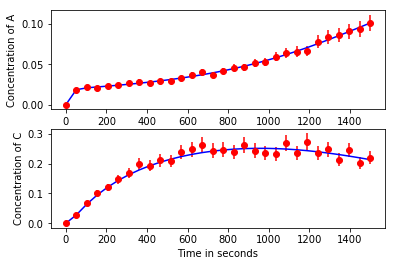

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CA"], 
             yerr=df_kinetic_data["errCA"],
             color = 'r', fmt = 'o', ecolor = 'r', capthick = 2)
ax1.plot(df_kinetic_data["Time"], CA_calc, 'b')
ax1.xaxis.label.set_text("Time in seconds")
ax1.yaxis.label.set_text("Concentration of A")

ax2.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CC"], 
             yerr=df_kinetic_data["errCC"],
             color = 'r', fmt = 'o', ecolor = 'r', capthick = 2)
ax2.plot(df_kinetic_data["Time"], CC_calc, 'b')
ax2.xaxis.label.set_text("Time in seconds")
ax2.yaxis.label.set_text("Concentration of C")

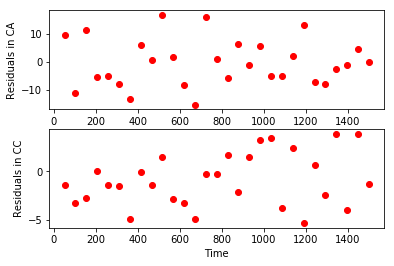

In [38]:
residuals = get_residuals3(optimized_parameters3["x"], 
                           parameters, 
                           df_kinetic_data, 
                           )
residuals_CA = residuals[:int(len(residuals)/2)]
residuals_CC = residuals[int(len(residuals)/2):]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(df_kinetic_data.iloc[1:]["Time"], residuals_CA, color = 'red')
ax1.xaxis.label.set_text("Time")
ax1.yaxis.label.set_text("Residuals in CA")

ax2.scatter(df_kinetic_data.iloc[1:]["Time"], residuals_CC, color = 'red')
ax2.xaxis.label.set_text("Time")
ax2.yaxis.label.set_text("Residuals in CC")

In [39]:
print("Shapiro-Wilk statistic and p-value for CA residuals",scipy.stats.shapiro(residuals_CA))
print("Shapiro-Wilk statistic and p-value for CC residuals",scipy.stats.shapiro(residuals_CC))
print('Mean and 95% confidence half-width for CA residuals',scipy.mean(residuals_CA), scipy.sqrt(scipy.var(residuals_CA))*1.96)
print('Mean and 95% confidence half-width for CC residuals',scipy.mean(residuals_CC), scipy.sqrt(scipy.var(residuals_CC))*1.96)

Shapiro-Wilk statistic and p-value for CA residuals (0.9708558917045593, 0.5831331014633179)
Shapiro-Wilk statistic and p-value for CC residuals (0.9594382047653198, 0.3183991014957428)
Mean and 95% confidence half-width for CA residuals -0.298167013419 16.1990274906
Mean and 95% confidence half-width for CC residuals -0.850598111063 5.24680186579


No pattern, passes the Shapiro test and has a mean at zero with 95% confidence.  

## Error Analysis
Let's get the covariance matrix first.  Only now we the TWO of them.  One for $C_A$ and the other for $C_C$!

In [40]:
kAB_opt, v0_opt, kC_opt = optimized_parameters3['x']

dn = 0.001
parameters["kAB"], parameters["v0"], parameters["kC"] = kAB_opt, v0_opt, kC_opt
CA_calc_opt, CC_calc_opt = solution3(parameters, df_kinetic_data)

parameters["kAB"], parameters["v0"], parameters["kC"] = kAB_opt*(1+dn), v0_opt, kC_opt
CA_calc_1, CC_calc_1 = solution3(parameters, df_kinetic_data)

parameters["kAB"], parameters["v0"], parameters["kC"] = kAB_opt, v0_opt*(1+dn), kC_opt
CA_calc_2, CC_calc_2 = solution3(parameters, df_kinetic_data)

parameters["kAB"], parameters["v0"], parameters["kC"] = kAB_opt, v0_opt, kC_opt*(1+dn)
CA_calc_3, CC_calc_3 = solution3(parameters, df_kinetic_data)

#Getting d1, d2, d3 for CA by numerical differentiation
d1_CA = (CA_calc_1 - CA_calc_opt)/(kAB_opt*dn); d1_CA = d1_CA[1:]
d2_CA = (CA_calc_2 - CA_calc_opt)/(v0_opt *dn); d2_CA = d2_CA[1:]
d3_CA = (CA_calc_3 - CA_calc_opt)/(kC_opt *dn); d3_CA = d3_CA[1:]

#Getting d1, d2, d3 for CC by numerical differentiation
d1_CC = (CC_calc_1 - CC_calc_opt)/(kAB_opt*dn); d1_CC = d1_CC[1:] 
d2_CC = (CC_calc_2 - CC_calc_opt)/(v0_opt *dn); d2_CC = d2_CC[1:]
d3_CC = (CC_calc_3 - CC_calc_opt)/(kC_opt *dn); d3_CC = d3_CC[1:]

errCA = df_kinetic_data.iloc[1:]["errCA"]
A_CA = scipy.array([list(d1_CA/errCA), list(d2_CA/errCA), list(d3_CA/errCA)]).T

errCC = df_kinetic_data.iloc[1:]["errCC"]
A_CC = scipy.array([list(d1_CC/errCC), list(d2_CC/errCC), list(d3_CC/errCC)]).T

H_CA = scipy.dot(A_CA.T, A_CA)
C_CA = scipy.linalg.inv(H_CA)
print("The covariance matrix with respect to CA is: ")
print(C_CA)

H_CC = scipy.dot(A_CC.T, A_CC)
C_CC = scipy.linalg.inv(H_CC)
print("The covariance matrix with respect to CC is: ")
print(C_CC)

The covariance matrix with respect to CA is: 
[[  8.08938165e-05   1.18242877e-08   3.12118279e-05]
 [  1.18242877e-08   1.78393300e-12   4.76469998e-09]
 [  3.12118279e-05   4.76469998e-09   1.29802853e-05]]
The covariance matrix with respect to CC is: 
[[  3.57144368e-04  -2.08224461e-08   5.34601078e-05]
 [ -2.08224461e-08   1.40043616e-12  -3.29584244e-09]
 [  5.34601078e-05  -3.29584244e-09   8.69585750e-06]]


In [41]:
print('kAB',parameters["kAB"])
print('Uncertainty in kAB with respect to CA is',
      1.96*scipy.sqrt(C_CA[0,0]),
      'i.e.',
      1.96*scipy.sqrt(C_CA[0,0])/parameters["kAB"]*100,
      'percent.')
print('95 percent confidence interval for k_AB with respect to CA is: (',
      parameters['kAB']-1.96*scipy.sqrt(C_CA[0,0]),
      ',',
      parameters['kAB']+1.96*scipy.sqrt(C_CA[0,0]),
      ')')
print('Uncertainty in kAB with respect to CC is',
      1.96*scipy.sqrt(C_CC[0,0]),
      'i.e.',
      1.96*scipy.sqrt(C_CC[0,0])/parameters["kAB"]*100,
      'percent.')
print('95 percent confidence interval for k_AB with respect to CC is: (',
      parameters['kAB']-1.96*scipy.sqrt(C_CC[0,0]),
      ',',
      parameters['kAB']+1.96*scipy.sqrt(C_CC[0,0]),
      ')')

kAB 0.0476155374055
Uncertainty in kAB with respect to CA is 0.0176284340049 i.e. 37.0224405005 percent.
95 percent confidence interval for k_AB with respect to CA is: ( 0.0299871034006 , 0.0652439714105 )
Uncertainty in kAB with respect to CC is 0.0370405966989 i.e. 77.7909873902 percent.
95 percent confidence interval for k_AB with respect to CC is: ( 0.0105749407066 , 0.0846561341045 )


In [42]:
print('v0',parameters["v0"])
print('Uncertainty in v0 with respect to CA is:',
      1.96*scipy.sqrt(C_CA[1,1]),
      'i.e.',
      1.96*scipy.sqrt(C_CA[1,1])/parameters["v0"]*100,
      'percent.')
print('95 percent confidence interval for v0 with respect to CA: (',
      parameters['v0']-1.96*scipy.sqrt(C_CA[1,1]),
      ',',
      parameters['v0']+1.96*scipy.sqrt(C_CA[1,1]),
      ')')
print('Uncertainty in v0 with respect to CC is:',
      1.96*scipy.sqrt(C_CC[1,1]),
      'i.e.',
      1.96*scipy.sqrt(C_CC[1,1])/parameters["v0"]*100,
      'percent.')
print('95 percent confidence interval for v0 with respect to CC: (',
      parameters['v0']-1.96*scipy.sqrt(C_CC[1,1]),
      ',',
      parameters['v0']+1.96*scipy.sqrt(C_CC[1,1]),
      ')')

v0 9.39284027186e-06
Uncertainty in v0 with respect to CA is: 2.61785350968e-06 i.e. 27.8707338134 percent.
95 percent confidence interval for v0 with respect to CA: ( 6.77498676217e-06 , 1.20106937815e-05 )
Uncertainty in v0 with respect to CC is: 2.3194644989e-06 i.e. 24.6939629736 percent.
95 percent confidence interval for v0 with respect to CC: ( 7.07337577296e-06 , 1.17123047708e-05 )


In [43]:
print('kC',parameters["kC"])
print('Uncertainty in kC with respect to CA is:',
      1.96*scipy.sqrt(C_CA[2,2]),
      'i.e.',
      1.96*scipy.sqrt(C_CA[2,2])/parameters["kC"]*100,
      'percent.')
print('95 percent confidence interval for kC with respect to CA: (',
      parameters['kC']-1.96*scipy.sqrt(C_CA[2,2]),
      ',',
      parameters['kC']+1.96*scipy.sqrt(C_CA[2,2]),
      ')')
print('Uncertainty in kC with respect to CC is:',
      1.96*scipy.sqrt(C_CC[2,2]),
      'i.e.',
      1.96*scipy.sqrt(C_CC[2,2])/parameters["kC"]*100,
      'percent.')
print('95 percent confidence interval for kC with respect to CC: (',
      parameters['kC']-1.96*scipy.sqrt(C_CC[2,2]),
      ',',
      parameters['kC']+1.96*scipy.sqrt(C_CC[2,2]),
      ')') 

kC 0.00254866829118
Uncertainty in kC with respect to CA is: 0.00706151995001 i.e. 277.067046129 percent.
95 percent confidence interval for kC with respect to CA: ( -0.00451285165883 , 0.0096101882412 )
Uncertainty in kC with respect to CC is: 0.00577979291776 i.e. 226.77697752 percent.
95 percent confidence interval for kC with respect to CC: ( -0.00323112462658 , 0.00832846120894 )


These are pretty high uncertainties and actually call into question the integrity of the model proposed.  It is very likely that the model is just wrong and another should be tried.  Anyway, sticking to this model, lets get the uncertainties in the best fit lines.  

In [44]:
D_CA = scipy.array([list(d1_CA), list(d2_CA), list(d3_CA)]).T
sigma_CA = []
for d in D_CA:
    sig = scipy.dot(d, scipy.dot(C_CA, d.T))
    sigma_CA.append(1.96*scipy.sqrt(sig)) #Where we have used the 95% interval.
sigma_CA = scipy.array(sigma_CA)
upper_bound_CA = CA_calc[1:] + sigma_CA
lower_bound_CA = CA_calc[1:] - sigma_CA
time = df_kinetic_data.iloc[1:]["Time"]

D_CC = scipy.array([list(d1_CC), list(d2_CC), list(d3_CC)]).T
sigma_CC = []
for d in D_CC:
    sig = scipy.dot(d, scipy.dot(C_CC, d.T))
    sigma_CC.append(1.96*scipy.sqrt(sig)) #Where we have used the 95% interval.
sigma_CC = scipy.array(sigma_CC)
upper_bound_CC = CC_calc[1:] + sigma_CC
lower_bound_CC = CC_calc[1:] - sigma_CC
time = df_kinetic_data.iloc[1:]["Time"]

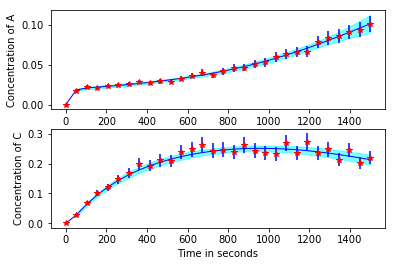

In [45]:
figure = plt.figure()
ax1 = figure.add_subplot(211)
ax2 = figure.add_subplot(212)

ax1.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CA"], 
             yerr=df_kinetic_data["errCA"],
             color = 'red', fmt = '*', ecolor = 'blue', capthick = 0.05)
ax1.plot(df_kinetic_data["Time"], CA_calc, 'blue', linewidth = 1.0)
ax1.fill_between(time, lower_bound_CA, upper_bound_CA, color='cyan', alpha = 0.5)
ax1.xaxis.label.set_text("Time in seconds")
ax1.yaxis.label.set_text("Concentration of A")

ax2.errorbar(x=df_kinetic_data["Time"], 
             y=df_kinetic_data["CC"], 
             yerr=df_kinetic_data["errCC"],
             color = 'red', fmt = '*', ecolor = 'blue', capthick = 0.05)
ax2.plot(df_kinetic_data["Time"], CC_calc, 'blue', linewidth = 1.0)
ax2.fill_between(time, lower_bound_CC, upper_bound_CC, color='cyan', alpha = 0.5)
ax2.xaxis.label.set_text("Time in seconds")
ax2.yaxis.label.set_text("Concentration of C")

Ok.  Not so bad.  The uncertainty in the fits is rather small.  Nothing like the uncertainty in the parameters.  It is possible that there is a superfluous parameter.  The only thing to do is to keep refining the model until you get reasonable uncertainties.  

Oh, and welcome to the real world. Yeah, its messy.  